<h1><center>Practice of Large Scale Machine Learning - TP1 Avazu<center></h1>
<h2><center>IA317<center></h2>


#Introduction

In online advertising, click-through rate (CTR) is a very important metric for evaluating ad performance. As a result, click prediction systems are essential and widely used for sponsored search and real-time bidding. The goal of this TP is to build and test prediction models on 11 days of Avazu data.

#### For any remark or suggestion, please feel free to contact us at: 
#### pascal.bianchi@telecom-paris.fr
#### nidham.gazagnadou@telecom-paris.fr
#### kevin.elgui@telecom-paris.fr

In [2]:
import sys
import os
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Colab Notebooks/tp_avazu'  # your new root path

sys.path.append(os.path.join(root_path, 'notebooks')) # for importing from utils.py

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


<font color="red">**Question:**
    Import the needed packages: numpy, pandas etc..
</font>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline

In [0]:
## Try to run de cell
from utils import plotlift

# The dataset

<font color="red">**Question:**
    Load the data *'data_tp/train-1000000'* into a pandas DataFrame. Use the function 'os.path.join()' to indicate the full path. Then, display the first lines with the ".head()" method.
    <br>
</font>
**Remark**: the features meaning is available at https://www.kaggle.com/c/avazu-ctr-prediction/data

In [0]:
df = pd.read_csv( os.path.join(root_path,'data/train-1000000') )

In [6]:
df. head() # Fill here

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,3.983206e+18,0,14102915,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,fb6566d3,be87996b,1,2,4687,320,50,423,2,39,100148,32
1,7.756884e+18,0,14103007,1002,0,cb809abf,74acf31a,50e219e0,ecad2386,7801e8d9,07d7df22,9b7af851,ac5a4a77,7e6190f3,0,0,17894,320,50,2039,2,39,100077,32
2,6.941774e+17,0,14102711,1005,0,85f751fd,c4e18dd6,50e219e0,e9739828,df32afa9,cef3e649,a99f214a,748e298a,3c55fad5,1,0,22684,320,50,2619,1,163,100055,71
3,2.664154e+18,1,14102903,1005,0,85f751fd,c4e18dd6,50e219e0,a5184c22,b8d325c3,0f2161f8,a99f214a,a50da3d4,c5cc73c1,1,0,23222,320,50,2676,0,35,100176,221
4,1.480510e+19,0,14102902,1005,1,791b5571,fd13bc73,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,d5f88679,a5bce124,1,0,8330,320,50,761,3,175,100081,23


<font color="red">**Question:**
    What is the 'click' frequency in the dataset?
    <br>
    Hint: 'click' is a binary output (0 or 1)
</font>

In [7]:
df['click'].sum() / df['click'].count() # Fill here

0.169971

Your answer here

The click frequency is 0.169971

We note that the Avazu dataset is very unbalanced. The 'click' class represents less than a fifth of the whole database. We already know that a classifier always predicting 'click'=0 will have good preformances in terms of error rate (around 0.17). The ROC and lift curves will be better performance metrics.

<font color="red">**Question:**
    What are the categorical features? Using the 'df.nunique()' method, compute the number of distincts values for each of these features.
</font>

In [8]:
df.nunique() # Fill here

id                  1000000
click                     2
hour                    240
C1                        7
banner_pos                7
site_id                2651
site_domain            2871
site_category            22
app_id                 3157
app_domain              198
app_category             26
device_id            150501
device_ip            555248
device_model           5168
device_type               5
device_conn_type          4
C14                    2243
C15                       8
C16                       9
C17                     420
C18                       4
C19                      66
C20                     163
C21                      60
dtype: int64

In [136]:
df.columns

Index(['id', 'click', 'hour', 'C1', 'banner_pos', 'site_category', 'app_id',
       'app_domain', 'app_category', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'weekday', 'user',
       'site'],
      dtype='object')

Your answer here

The categorical features are: 'hour', 'C1', 'banner_pos', 'site_category', 'app_id',
       'app_domain', 'app_category', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'weekday', 'user'

<font color="red">**Question:**
    If one does a dummy encoding of all categorical variables, what would be the dimension of the model?
    In other words: what would be the dimension of our big feature vector encoded with dummies. 
    <br>
    Hint: if you have just 1 feature with 3 categories A, B and C, you would have a vector of dimension 3 (or 2 if you use drop_first=True).
</font>

In [9]:
df.nunique().values  

array([1000000,       2,     240,       7,       7,    2651,    2871,
            22,    3157,     198,      26,  150501,  555248,    5168,
             5,       4,    2243,       8,       9,     420,       4,
            66,     163,      60])

In [135]:
df.nunique().values.sum()

1781935

Your answer here

The dimension of our big feature vector encoded with dummies would be 1781935 (or 1781911 use drop_first=True).

<font color="red">**Question:**
    Analyze the 'hour' column: which format is used? How can we transform/simply this feature?
</font>

In [10]:
print(df[ 'hour' ].head()) # Fill here
print(df[ 'hour' ].tail()) # Fill here

0    14102915
1    14103007
2    14102711
3    14102903
4    14102902
Name: hour, dtype: int64
999995    14102602
999996    14102101
999997    14102318
999998    14102908
999999    14102600
Name: hour, dtype: int64


Your answer here

It use the format yy-mm-dd-hh and we could extract the hour and weekday as the new features.

<font color="red">**Question:**
    Run and understand the following script.
</font>

In [11]:
import datetime

def datesplit(originalDate):
    originalDate = str(originalDate)
    
    year = int("20" + originalDate[0:2])
    month = int(originalDate[2:4])
    day = int(originalDate[4:6])
    hour = int(originalDate[6:8])
    
    return datetime.datetime(year, month, day, hour)

# Exemple :
datesplit(14102915).weekday(), datesplit(14102915).hour

(2, 15)

<font color="red">**Question:**
    Using the ".apply( ... )" method, create a 'weekday' for the day of the week. Then, replace the 'hour' column by the hour.
</font>

To answer this question you have to understand that applies takes a function as argument
<br>
"lambda x: ... " is used to create local unamed function of x
<br>
Check the documentation: https://docs.python.org/3/tutorial/controlflow.html#lambda-expressions

In [0]:
df['weekday'] = df['hour'].apply(lambda x: datesplit(x).weekday() ) # Fill here
df['hour'] = df['hour'].apply(lambda x: datesplit(x).hour ) # Fill here

<font color="red">**Question:**
    Using the ".groupby( ... )" method, visualize the influence of the hour and of the day on the 'click' frequency (take the ".mean()"!). To do so, plot 'click' vs 'hour' and 'click' vs 'weekday' curves.
    <br>
    Precise the name of the axes.
</font>

In [13]:
df.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,weekday
0,3.983206e+18,0,15,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,fb6566d3,be87996b,1,2,4687,320,50,423,2,39,100148,32,2
1,7.756884e+18,0,7,1002,0,cb809abf,74acf31a,50e219e0,ecad2386,7801e8d9,07d7df22,9b7af851,ac5a4a77,7e6190f3,0,0,17894,320,50,2039,2,39,100077,32,3
2,6.941774e+17,0,11,1005,0,85f751fd,c4e18dd6,50e219e0,e9739828,df32afa9,cef3e649,a99f214a,748e298a,3c55fad5,1,0,22684,320,50,2619,1,163,100055,71,0
3,2.664154e+18,1,3,1005,0,85f751fd,c4e18dd6,50e219e0,a5184c22,b8d325c3,0f2161f8,a99f214a,a50da3d4,c5cc73c1,1,0,23222,320,50,2676,0,35,100176,221,2
4,1.480510e+19,0,2,1005,1,791b5571,fd13bc73,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,d5f88679,a5bce124,1,0,8330,320,50,761,3,175,100081,23,2


In [14]:
print(df.groupby( 'hour' )[ 'click' ].mean()) # Fill here for the influence of the hour
print(df.groupby( 'weekday' )[ 'click' ].mean()) # Fill here for the influence of the day

hour
0     0.182707
1     0.185734
2     0.175552
3     0.175367
4     0.159664
5     0.162126
6     0.169315
7     0.177490
8     0.163418
9     0.159042
10    0.162613
11    0.171025
12    0.171659
13    0.168032
14    0.178075
15    0.183737
16    0.180076
17    0.173271
18    0.164072
19    0.165725
20    0.158402
21    0.162384
22    0.166847
23    0.170733
Name: click, dtype: float64
weekday
0    0.183143
1    0.161577
2    0.158675
3    0.173795
4    0.173392
5    0.183995
6    0.183105
Name: click, dtype: float64


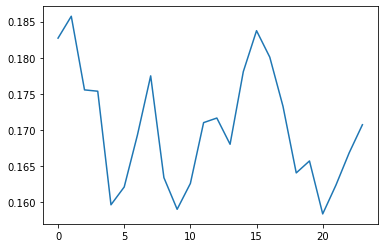

In [15]:
plt.plot(df.groupby( 'hour' ).mean()[ 'click' ]); # Fill here for the influence of the hour

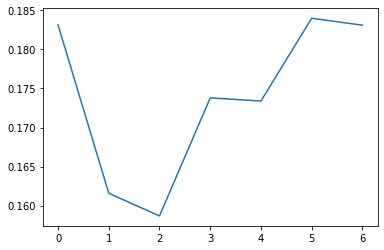

In [16]:
plt.plot(df.groupby( 'weekday' ).mean()[ 'click' ]); # Fill here for the influence of the day

# Preliminary work and first model

Start by understanding the features with few modalities:
'hour', 'weekday', 'C1', 'banner_pos', 'site_category', 'app_category', 'device_type', 'device_conn_type', 'C15', 'C16', 'C18', 'C21'.

<font color="red">**Question:**
    For instance, inspect the columns 'C15' (dimension of the advert) and 'site_category': visualize the clicks mean.
</font>

In [17]:
df.groupby('C15')['click'].mean() # Fill here: inspect 'C15' using '.groupby'

C15
120     0.033708
216     0.129612
300     0.360537
320     0.158767
480     0.285714
728     0.054144
768     0.375000
1024    0.166667
Name: click, dtype: float64

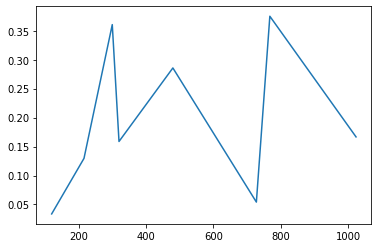

In [18]:
plt.plot(df.groupby('C15')['click'].mean())

In [19]:
df.groupby('site_category')['click'].mean()
 # Fill here: inspect 'site_category' using '.groupby'

site_category
0569f928    0.053613
28905ebd    0.208076
335d28a8    0.089824
3e814130    0.284245
42a36e14    0.225806
50e219e0    0.128597
5378d028    0.000000
70fb0e29    0.144737
72722551    0.059172
75fa27f6    0.111305
76b2941d    0.035756
8fd0aea4    0.015873
9ccfa2ea    0.000000
a818d37a    0.000000
bcf865d9    0.000000
c0dd3be3    0.128655
c706e647    0.000000
da34532e    0.000000
dedf689d    0.530449
e787de0e    0.000000
f028772b    0.179719
f66779e6    0.034564
Name: click, dtype: float64

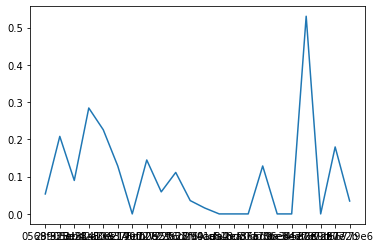

In [20]:
plt.plot(df.groupby('site_category')['click'].mean())

<font color="red">**Question:**
    Some site categories have a null click rate. Why? Display the 'count()' of each modality.
    <br><br>
    Hint: you can use the method ".value_counts()"
</font>

In [21]:
df[ 'site_category' ]. value_counts() # Fill here

50e219e0    408921
f028772b    313339
28905ebd    182020
3e814130     75667
f66779e6      6365
75fa27f6      4007
335d28a8      3351
76b2941d      2573
c0dd3be3      1026
72722551       676
dedf689d       624
70fb0e29       608
0569f928       429
8fd0aea4       189
a818d37a        81
42a36e14        62
e787de0e        28
bcf865d9        16
5378d028        11
9ccfa2ea         5
da34532e         1
c706e647         1
Name: site_category, dtype: int64

In [22]:
df[df['click']==1][ 'site_category' ]. value_counts() # Fill here

f028772b    56313
50e219e0    52586
28905ebd    37874
3e814130    21508
75fa27f6      446
dedf689d      331
335d28a8      301
f66779e6      220
c0dd3be3      132
76b2941d       92
70fb0e29       88
72722551       40
0569f928       23
42a36e14       14
8fd0aea4        3
Name: site_category, dtype: int64

It is practical to visualize both columns in parallel:

In [23]:
col = 'C1'
a = pd.DataFrame([df.groupby(col).mean()['click'], df.groupby(col).count()['click']]).transpose()
a.columns = ['mean', 'count']
a.sort_values(by='count', ascending=False)

,mean,count
C1,,
1005,0.169474,918606.0
1002,0.211157,54907.0
1010,0.095497,22409.0
1012,0.177295,2854.0
1007,0.035591,871.0
1001,0.027027,222.0
1008,0.106870,131.0


Your answer here

In some site category, there are not much visit so there isn't the clicks.

<font color="red">**Question:**
    Divide the dataset into a training and test set with sklearn (use the following options: test_size=0.1, random_state=100).
    <br>
    Warning: do not use 'id' as a feature.
</font>

In [24]:
df.columns
col=df.columns[2:]
col

Index(['hour', 'C1', 'banner_pos', 'site_id', 'site_domain', 'site_category',
       'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip',
       'device_model', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16',
       'C17', 'C18', 'C19', 'C20', 'C21', 'weekday'],
      dtype='object')

In [0]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(df[col],df['click'],test_size=0.1,random_state=100)

In [26]:
Xtest.columns

Index(['hour', 'C1', 'banner_pos', 'site_id', 'site_domain', 'site_category',
       'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip',
       'device_model', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16',
       'C17', 'C18', 'C19', 'C20', 'C21', 'weekday'],
      dtype='object')

# First work on a reduced number of features

<font color="red">**Question:**
    Put in a list the selected columns: 'hour', 'weekday', 'C1', 'banner_pos', 'site_category', 'app_category', 'device_type', 'device_conn_type', 'C15', 'C16', 'C18', 'C21'.
</font>

In [0]:
some_columns = ['hour', 'weekday', 'C1', 'banner_pos', 'site_category', 'app_category', 
                'device_type', 'device_conn_type', 'C15', 'C16', 'C18', 'C21']

<font color="red"> - Importer CategoricalEncoder de sklearn.preprocessing.  
- Fitter le CategoricalEncoder sur les données de train restreintes aux colonnes ci-dessus.  
- Transformer les données de train et de test en dummies.
</font>

<font color="red">**Question:**
    <br>
    - Import OneHotEncoder from sklearn.preprocessing
    <br>
    - Transform the training and the test data restricted to the selected columns
</font>

In [28]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

ohe = OneHotEncoder(sparse=False)
temp=Xtrain[some_columns]
#Xtrain_oh = pd.get_dummies(Xtrain[some_columns]) # fit the transformation of Xtrain restricted to selected columns
#Xtest_oh = pd.get_dummies(Xtest[some_columns]) # and transform Xtest restricted to selected columns
for col in some_columns:
  temp[col]=LabelEncoder().fit_transform(temp[col])
Xtrain_oh=ohe.fit_transform(temp)
temp=Xtest[some_columns]
for col in some_columns:
  temp[col]=LabelEncoder().fit_transform(temp[col])
Xtest_oh=ohe.transform(temp)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/i

In [29]:
Xtest_oh.shape

(100000, 183)

<font color="red">**Question:**
    What is the new number of features?
</font>

In [30]:
Xtest_oh.shape[1]

183

Your answer here

the new number of features is 183.

<font color="red">**Question:**
    Visualize the first row of the design matrix you have got. Do not forget to convert it into a "numpy.array" using the method ".toarray()".
</font>

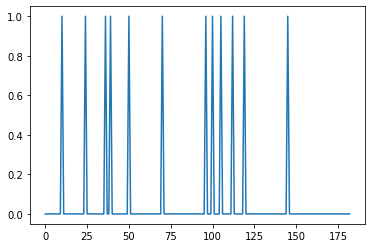

In [31]:
plt.plot(Xtrain_oh[ 0 ])

<font color="red">**Question:**
    Import and fit a logistic regression model on your the encoded data.
</font>

In [32]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(Xtrain_oh,ytrain)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

<font color="red">**Question:**
    With '.predict' and 'predict_proba', display the hard and soft decision you get on test data.
</font>

In [0]:
hard = lr.predict(Xtest_oh)
soft = lr.predict_proba(Xtest_oh)

<font color="red">**Question:**
    Compute the probability of error using sklearn.metrics 'accuracy_score' function. Comment.
</font>

In [34]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest,hard) # Fill here

0.82766

In [35]:
soft

array([[0.84726876, 0.15273124],
       [0.73406323, 0.26593677],
       [0.87415125, 0.12584875],
       ...,
       [0.87118132, 0.12881868],
       [0.86634058, 0.13365942],
       [0.92758661, 0.07241339]])

Your answer here

The probability or error is 0.173. It seems to be hard to define whether the prediction is good. We need to use other method, like roc curve to compare the 
performance.

<font color="red">**Question:**
    Plot the ROC curve. Then compute the log loss and the Area Under the Curve ROC.
</font>

Text(0.5, 1.0, 'ROC curve')

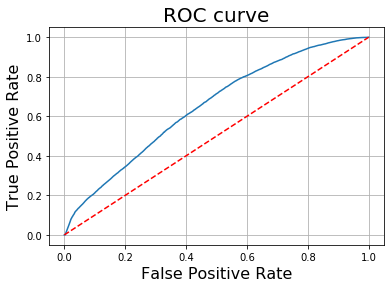

In [36]:
from sklearn.metrics import roc_curve

false_pos_rate, true_pos_rate, _ = roc_curve( ytest,soft[:,1] )
plt.plot(false_pos_rate,true_pos_rate)

plt.grid()
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=20)

In [37]:
from sklearn.metrics import log_loss , roc_auc_score

log_loss( ytest,soft[:,1] ), roc_auc_score( ytest,soft[:,1] )

(0.4383560197043325, 0.6502534528152853)

<font color="red">**Question:**
    Import the 'plot_lift' function from 'utils.py' and plot the lift curve. What is the lift of the first fifth of the population identified by the test?
</font>

[]

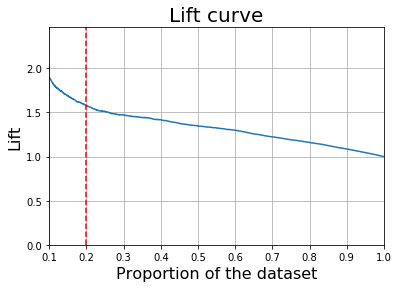

In [38]:
from utils import plotlift

plotlift(ytest,soft[:,1])
# The following line just plots a vertical line for you to answer the second part of the question
plt.axvline(x= 0.2 , linestyle='--', color='r') # Fill here

plt.xlabel('Proportion of the dataset', fontsize=16)
plt.ylabel('Lift', fontsize=16)
plt.title('Lift curve', fontsize=20)
plt.plot()

Your answer here

the lift of the first fifth of the population identified by the test is about 1.6

# Complete model

As an example, we now focus on the 'site_id' column.

<font color="red">**Question:**
    <br>
    - For each modality, compute the number of occurrences in the dataset and the average of clicks for this modality 
    <br>
    - With 'sns.joiplot', represent the set of points (count, mean) for each modality
</font>

In [0]:
import seaborn as sns

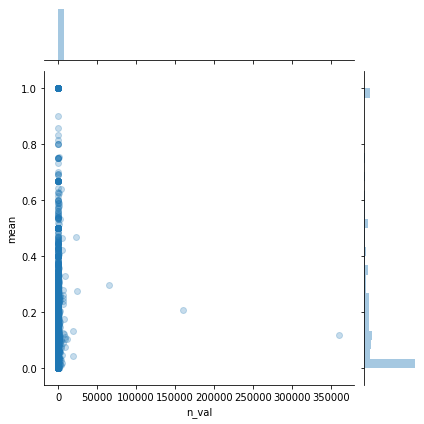

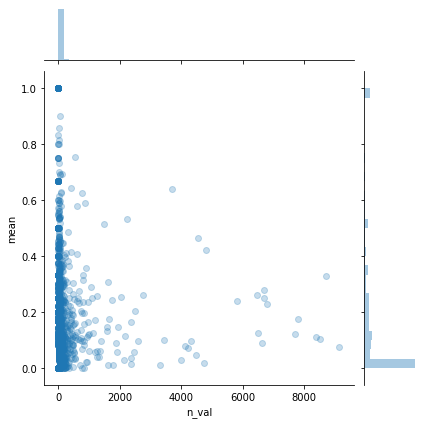

In [40]:
col = 'site_id'
a = pd.DataFrame([df.groupby(col).mean()['click'], df.groupby(col).count()['click']]).transpose()
a.columns = ['mean', 'n_val']
sns.jointplot(a['n_val'], a['mean'], alpha=0.25);
thres = 10000
sns.jointplot(a[a['n_val']<thres]['n_val'], a[a['n_val']<thres]['mean'], alpha=0.25);

<font color="red">**Question:**
    In the above commands, what does the alpha parameter stand for?
</font>

Your answer here

It decides the transparency in data visualization.

Several sites with a lot of occurrences in the dataset have a click frequency very different from the mean. It is relevant to keep the column 'site_id' at least for the modalities for which 'count' is very high.

<font color="red">**Question:**
    Do the same work on the 'device_id' column. What do you notice? What could be the isolated point?
</font>

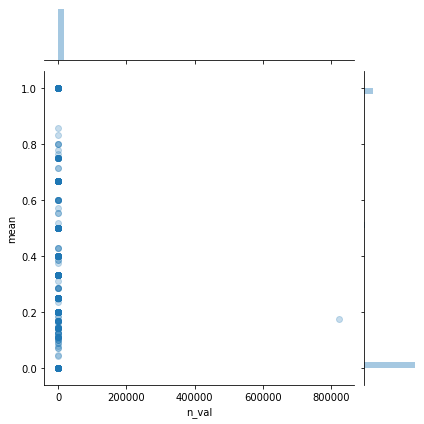

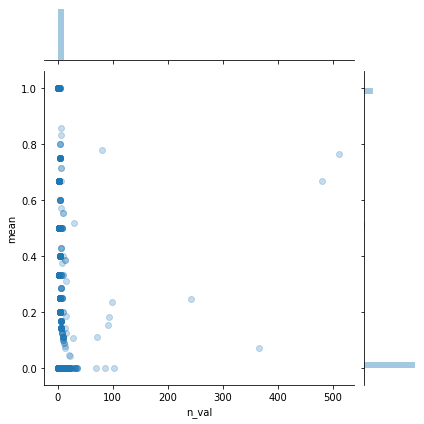

In [41]:
col = 'device_id' # Fill here
a = pd.DataFrame([df.groupby(col).mean()['click'], df.groupby(col).count()['click']]).transpose()
a.columns = ['mean', 'n_val']
sns.jointplot(a['n_val'], a['mean'], alpha=0.25);
thres = 10000
sns.jointplot(a[a['n_val']<thres]['n_val'], a[a['n_val']<thres]['mean'], alpha=0.25);

Your answer here

There are some data has the big n_val and they could be the isolated point.

<font color="red">**Question**:   
    In the column df['device_id'], spot the value V corresponding to the largest number of 'count' (using '.value_counts' method). Create a new column df['user'] defined as follows:
</font>
$$
\text{user} = \left\{\begin{array}[h]{ll} \text{device_ip + device_model} & \text{if device_id = V}\\ \text{device_id} & \text{else.}\end{array}\right.
$$

In [42]:
df['device_id'].value_counts()

a99f214a    824918
0f7c61dc       512
c357dbff       481
936e92fb       366
afeffc18       242
             ...  
e77bfb88         1
2cdd063e         1
e36154f0         1
2457180a         1
39ab5301         1
Name: device_id, Length: 150501, dtype: int64

In [0]:
V = 'a99f214a' # Fill here
df['user'] = (df['device_ip'] + df['device_model']) * (df['device_id']==V) + df['device_id'] * (df['device_id']!=V)

<font color="red">**Question**:
    Drop the following columns: 'device_id', 'device_model' and 'device_ip'
</font>

In [44]:
df.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,weekday,user
0,3.983206e+18,0,15,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,fb6566d3,be87996b,1,2,4687,320,50,423,2,39,100148,32,2,fb6566d3be87996b
1,7.756884e+18,0,7,1002,0,cb809abf,74acf31a,50e219e0,ecad2386,7801e8d9,07d7df22,9b7af851,ac5a4a77,7e6190f3,0,0,17894,320,50,2039,2,39,100077,32,3,9b7af851
2,6.941774e+17,0,11,1005,0,85f751fd,c4e18dd6,50e219e0,e9739828,df32afa9,cef3e649,a99f214a,748e298a,3c55fad5,1,0,22684,320,50,2619,1,163,100055,71,0,748e298a3c55fad5
3,2.664154e+18,1,3,1005,0,85f751fd,c4e18dd6,50e219e0,a5184c22,b8d325c3,0f2161f8,a99f214a,a50da3d4,c5cc73c1,1,0,23222,320,50,2676,0,35,100176,221,2,a50da3d4c5cc73c1
4,1.480510e+19,0,2,1005,1,791b5571,fd13bc73,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,d5f88679,a5bce124,1,0,8330,320,50,761,3,175,100081,23,2,d5f88679a5bce124


In [45]:
todrop=['device_id','device_model','device_ip']
df=df.drop(todrop,axis=1)
df.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,weekday,user
0,3.983206e+18,0,15,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,1,2,4687,320,50,423,2,39,100148,32,2,fb6566d3be87996b
1,7.756884e+18,0,7,1002,0,cb809abf,74acf31a,50e219e0,ecad2386,7801e8d9,07d7df22,0,0,17894,320,50,2039,2,39,100077,32,3,9b7af851
2,6.941774e+17,0,11,1005,0,85f751fd,c4e18dd6,50e219e0,e9739828,df32afa9,cef3e649,1,0,22684,320,50,2619,1,163,100055,71,0,748e298a3c55fad5
3,2.664154e+18,1,3,1005,0,85f751fd,c4e18dd6,50e219e0,a5184c22,b8d325c3,0f2161f8,1,0,23222,320,50,2676,0,35,100176,221,2,a50da3d4c5cc73c1
4,1.480510e+19,0,2,1005,1,791b5571,fd13bc73,f028772b,ecad2386,7801e8d9,07d7df22,1,0,8330,320,50,761,3,175,100081,23,2,d5f88679a5bce124


<font color="red">**Question**:
    One could look at the similarity between 'site_id' and 'site_domain'. Merge those columns into a new 'site' column (using the '+' operator)  and delete the old 'site_id' and 'site_domain' columns.
</font>

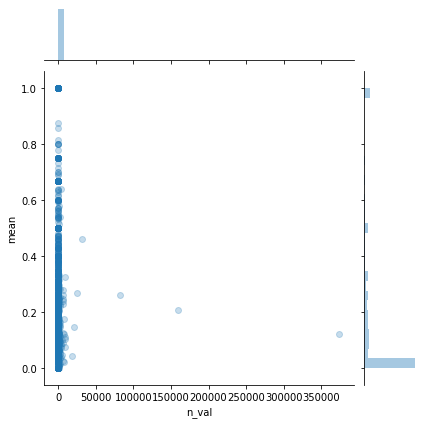

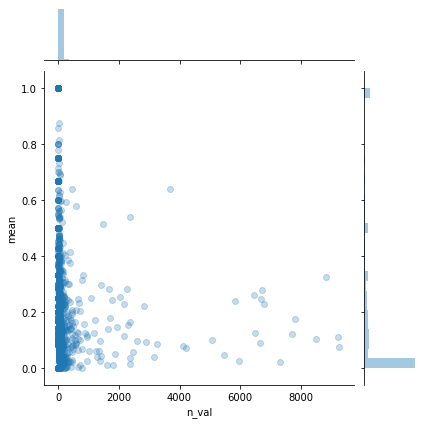

In [46]:
col = 'site_domain' # Fill here
a = pd.DataFrame([df.groupby(col).mean()['click'], df.groupby(col).count()['click']]).transpose()
a.columns = ['mean', 'n_val']
sns.jointplot(a['n_val'], a['mean'], alpha=0.25);
thres = 10000
sns.jointplot(a[a['n_val']<thres]['n_val'], a[a['n_val']<thres]['mean'], alpha=0.25);

In [47]:
df['site_id'].value_counts()

85f751fd    360911
1fbe01fe    159924
e151e245     65231
d9750ee7     24090
5b08c53b     22524
             ...  
fc112a3d         1
e4df8ca8         1
cd4909d0         1
7a0f9a7f         1
f5ed5386         1
Name: site_id, Length: 2651, dtype: int64

In [48]:
df['site_domain'].value_counts()

c4e18dd6    374158
f3845767    159924
7e091613     82263
7687a86e     31858
98572c79     24879
             ...  
4dc4660a         1
a6bffa37         1
257bfe3b         1
3e7bcc29         1
abb08d8f         1
Name: site_domain, Length: 2871, dtype: int64

In [49]:
df['site']=df['site_id']+df['site_domain']
df.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,weekday,user,site
0,3.983206e+18,0,15,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,1,2,4687,320,50,423,2,39,100148,32,2,fb6566d3be87996b,e151e2457e091613
1,7.756884e+18,0,7,1002,0,cb809abf,74acf31a,50e219e0,ecad2386,7801e8d9,07d7df22,0,0,17894,320,50,2039,2,39,100077,32,3,9b7af851,cb809abf74acf31a
2,6.941774e+17,0,11,1005,0,85f751fd,c4e18dd6,50e219e0,e9739828,df32afa9,cef3e649,1,0,22684,320,50,2619,1,163,100055,71,0,748e298a3c55fad5,85f751fdc4e18dd6
3,2.664154e+18,1,3,1005,0,85f751fd,c4e18dd6,50e219e0,a5184c22,b8d325c3,0f2161f8,1,0,23222,320,50,2676,0,35,100176,221,2,a50da3d4c5cc73c1,85f751fdc4e18dd6
4,1.480510e+19,0,2,1005,1,791b5571,fd13bc73,f028772b,ecad2386,7801e8d9,07d7df22,1,0,8330,320,50,761,3,175,100081,23,2,d5f88679a5bce124,791b5571fd13bc73


In [50]:
todrop=['site_id','site_domain']
df=df.drop(todrop,axis=1)
df.head()

,id,click,hour,C1,banner_pos,site_category,app_id,app_domain,app_category,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,weekday,user,site
0,3.983206e+18,0,15,1005,1,f028772b,ecad2386,7801e8d9,07d7df22,1,2,4687,320,50,423,2,39,100148,32,2,fb6566d3be87996b,e151e2457e091613
1,7.756884e+18,0,7,1002,0,50e219e0,ecad2386,7801e8d9,07d7df22,0,0,17894,320,50,2039,2,39,100077,32,3,9b7af851,cb809abf74acf31a
2,6.941774e+17,0,11,1005,0,50e219e0,e9739828,df32afa9,cef3e649,1,0,22684,320,50,2619,1,163,100055,71,0,748e298a3c55fad5,85f751fdc4e18dd6
3,2.664154e+18,1,3,1005,0,50e219e0,a5184c22,b8d325c3,0f2161f8,1,0,23222,320,50,2676,0,35,100176,221,2,a50da3d4c5cc73c1,85f751fdc4e18dd6
4,1.480510e+19,0,2,1005,1,f028772b,ecad2386,7801e8d9,07d7df22,1,0,8330,320,50,761,3,175,100081,23,2,d5f88679a5bce124,791b5571fd13bc73


<font color="red">**Question**:
    Once again, split the modified DataFrame 'df' into a train and a test set (with options: test_size=0.1 and random_state=100).
    <br>
    Warning: do not use 'id' as a feature.
</font>

In [0]:
col=df.columns[2:]
Xtrain, Xtest, ytrain, ytest = Xtrain, Xtest, ytrain, ytest = train_test_split(df[col],df['click'],test_size=0.1,random_state=100)

<font color="red">**Question**:
    Define a OneHotEncoder and then, 'fit_transform' the train set.
</font>

In [0]:
ohe = OneHotEncoder(handle_unknown='ignore')
Xtrain_oh = ohe.fit_transform(Xtrain) # Fill here

<font color="red">**Question**:
    Transform the test set. If an error occurs, analyze it and try to solve it by modifying the parameter "handle_unkown" of the OneHotEncoder. 
    <br>
    Explain your the problem you encouter and how you solved it. 
</font>

In [0]:
Xtest_oh = ohe.transform(Xtest) # Fill here

Your answer here

It appears some number that we haven't find in the trainning set so we just ignore these occasion.

<font color="red">**Question**:
    What is the new number of features?
</font>

In [54]:
Xtest_oh.shape,Xtrain_oh.shape

((100000, 713334), (900000, 713334))

Your answer here

713334

<font color="red">**Question**:
    How many modalities have been seen more than a 100 times?
</font>

In [55]:
# The following 'n_ones' vector below gives the number of '1' in each column/modality of the Xtrain_oh design matrix.
n_ones = np.array(Xtrain_oh.sum(axis=0))
(n_ones>100).sum() # Fill here using 'n_ones'

1971

Your answer here

1971

The list 'cols_to_keep' below is used to store the indices of the modalities seen more than a 100 times. 

<font color="red">**Question**:
    How does the `enumerate` function work?
</font>

In [0]:
useful = np.array(n_ones>100)[0]
cols_to_keep = [i for i,b in enumerate(useful) if b]

Your answer here

It generate the index and the value for an array or a list.

<font color="red">**Question**:
    Using only our restriction on the 'cols_to_keep' columns, retrain a logistic regression model and compare its performance in terms of 'log_loss' and 'roc_auc_curve'.
</font>

In [57]:
lr = LogisticRegression()
lr.fit( Xtrain_oh[:,cols_to_keep],ytrain )
soft = lr.predict_proba(Xtest_oh[:,cols_to_keep])
log_loss( ytest,soft[:,1] ), roc_auc_score( ytest,soft[:,1] )

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.40115384962973016, 0.7385969297244755)

In [58]:
hard=lr.predict(Xtest_oh[:,cols_to_keep])
accuracy_score(ytest,hard) # Fill here

0.83373

# Gradient Boosting Decision Trees

<font color="red">**Question**:
    <br>
    - Import GradientBoostingClassifier from scikit learn. 
    <br>
    - Initialize it using 50 estimators and a learning rate of 0.8. Set 'verbose=True' to monitor the progress of the training step.
    <br>
    - Fit it on the same columns 'cols_to_keep' of Xtrain_oh than for the previous logistic regression.
    <br>
    - Evaluate its performance as in the previous step.
</font>

In [0]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(verbose=1,learning_rate=0.8,n_estimators=50) # Fill here

In [0]:
gb.fit( Xtrain_oh[:,cols_to_keep],ytrain )

      Iter       Train Loss   Remaining Time 
         1           0.8743            2.00m
         2           0.8646            1.87m
         3           0.8583            1.81m
         4           0.8535            1.75m
         5           0.8503            1.71m
         6           0.8464            1.67m
         7           0.8441            1.63m
         8           0.8418            1.59m
         9           0.8404            1.55m
        10           0.8383            1.50m
        20           0.8282            1.13m
        30           0.8234           44.95s
        40           0.8190           22.49s
        50           0.8163            0.00s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.8, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=1,
                           warm_start=False)

In [0]:
soft = gb.predict_proba(Xtest_oh[:,cols_to_keep])[:,1]
log_loss(ytest, soft), roc_auc_score(ytest, soft)

(0.4091871736006742, 0.7251893509766301)

<font color="red">**Question**:
    What does the 'gb.estimators_' output?
</font>

In [0]:
gb.estimators_

array([[DecisionTreeRegressor(criterion='friedman_mse', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort='auto',
                      random_state=RandomState(MT19937) at 0x7F896E0C4A98,
                      splitter='best')],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort='auto',
                      random_state=RandomState(MT19937) at 0x7F896E0C4A98,
                      splitter='best')],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3, max_features=None,
        

Your answer here

It shows the basic classier trees in the forest model.

We now try to use the 'gb' classifier to generate features that will be relevant inputs for the logistic regression.

<font color="red">**Question**:
    With the 'gb.apply()' method, generate a transformation 'leafs_train' of the training set 'Xtrain_oh[:, cols_to_keep]' for which the n-th column corresponds to the number of the leaf returned by the estimator n.
</font>

In [0]:
# Test here the gb.apply method on Xtrain[:, cols_to_keep]
app=gb.apply(Xtrain_oh[:, cols_to_keep])
app

array([[[ 3.],
        [ 3.],
        [ 3.],
        ...,
        [ 3.],
        [ 3.],
        [ 3.]],

       [[ 3.],
        [ 3.],
        [ 3.],
        ...,
        [ 3.],
        [ 3.],
        [ 3.]],

       [[ 3.],
        [ 3.],
        [ 3.],
        ...,
        [ 3.],
        [ 3.],
        [ 3.]],

       ...,

       [[ 3.],
        [ 3.],
        [ 3.],
        ...,
        [ 3.],
        [ 3.],
        [ 3.]],

       [[ 3.],
        [ 3.],
        [ 3.],
        ...,
        [ 3.],
        [ 3.],
        [ 3.]],

       [[ 3.],
        [13.],
        [ 3.],
        ...,
        [ 3.],
        [ 3.],
        [ 3.]]])

In [0]:
app[0,:,0]

array([ 3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3., 10.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        4.,  3.,  4.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  4.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.])

After your applied gb.apply on Xtrain_oh[:, cols_to_keep], remember that we have only one class to predict (click = 0 or 1). So, do not forget to slice your output with [:, :, 0] in order to keep, firstly, all the samples, and secondly all your 50 estimators.

Hint: you can have a look at the dimensions of your output with .shape !

In [0]:
leafs_train = pd.DataFrame(gb.apply(Xtrain_oh[:, cols_to_keep])[:,:,0] ) # Fill here
leafs_test = pd.DataFrame(gb.apply(Xtest_oh[:, cols_to_keep])[:,:,0] )

<font color="red">**Question**:
    Encode these new features into dummies.
</font>

In [0]:
ohe = OneHotEncoder( handle_unknown='ignore' ) # Fill here an argument if needed
leafs_train_oh = ohe.fit_transform(leafs_train)
leafs_test_oh = ohe.transform(leafs_test)

<font color="red">**Question**:
    With the "hstack" function, create a new matrix of features by concatenating horizontally our new features "leafs_train_oh" and "leafs_test_oh", and previous features used for logistic regression (e.g. in "Xtrain_oh[:, cols_to_keep]").
</font>
<br><br>
**Remark**: we use "hstack" from scipy.sparse (and not from numpy) because the output of our OneHotEncoder is a sparse array. You can verify it with the command "type(Xtrain_oh)".

In [0]:
from scipy.sparse import csr_matrix, hstack

Xtrain_concat = hstack([ Xtrain_oh[:, cols_to_keep] , leafs_train_oh ]) # Fill here
Xtest_concat = hstack([ Xtest_oh[:, cols_to_keep] , leafs_test_oh ])

<font color="red">**Question**:
    Run a logistic regression on the new features and evaluate its performance as before. 
    <br>
    Warning: be patient, fitting should take about 5 minutes on Google Colab.
</font>

In [0]:
Xtrain_concat.shape

(900000, 2367)

In [0]:
lr = LogisticRegression()
lr.fit( Xtrain_concat,ytrain )
soft = lr.predict_proba(Xtest_concat)
log_loss( ytest,soft[:,1] ), roc_auc_score( ytest,soft[:,1] )

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.3999550525605989, 0.7417378154117085)

In [0]:
hard=lr.predict(Xtest_concat)
accuracy_score(ytest,hard) # Fill here

0.83407

<font color="red">**Question**:
    <br>
    - Import XGBClassifier from xgboost package.
    <br>
    - Initialize it using the same number of estimators and learning rate as before. Set the 'n_jobs' to -1.
    <br>
    - Fit it on the same columns 'cols_to_keep' of Xtrain_oh than for the previous logistic regression.
    <br>
    - Evaluate its performance and compare it to the GradientBoosting classifier of scikit learn. How is the error? Does it take more time to run?
</font>

In [0]:
from xgboost import XGBClassifier

xgb = XGBClassifier( learning_rate=0.8 , n_estimators=50 , n_jobs=-1 , verbosity=2)
%time xgb.fit( Xtrain_oh[:,cols_to_keep],ytrain )

[18:41:31] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:41:32] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:41:32] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:41:32] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:41:33] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:41:33] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:41:34] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[18:41:34] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nod

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.8, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=50, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=2)

In [0]:
soft = xgb.predict_proba(Xtest_oh[:,cols_to_keep])
hard=xgb.predict(Xtest_oh[:,cols_to_keep])
log_loss( ytest,soft[:,1] ), roc_auc_score( ytest,soft[:,1] ),accuracy_score(ytest,hard)

(0.40789666015213355, 0.7244454605414952, 0.83298)

<font color="red">**Question**:
    Increase the number of estimators and visualize the impact on performance. You might have to adapt the learning rate. On Google Colab, here are the approximate training times<br> 
    - nb_estimators=256  and lr=0.8 ~  4 min<br>
    - nb_estimators=512  and lr=0.6 ~  8 min<br>
    - nb_estimators=1024 and lr=0.5 ~ 16 min
</font>

In [0]:
loss=[]
roc=[]
accuracy=[]

In [0]:
xgb = XGBClassifier( learning_rate=0.8 , n_estimators=256 , n_jobs=-1)
%time xgb.fit( Xtrain_oh[:,cols_to_keep],ytrain )

CPU times: user 3min 7s, sys: 423 ms, total: 3min 7s
Wall time: 1min 37s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.8, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=256, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
soft = xgb.predict_proba(Xtest_oh[:,cols_to_keep])
hard=xgb.predict(Xtest_oh[:,cols_to_keep])
loss.append(log_loss( ytest,soft[:,1] ))
roc.append( roc_auc_score( ytest,soft[:,1] ))
accuracy.append(accuracy_score(ytest,hard))

In [0]:
xgb = XGBClassifier( learning_rate=0.6 , n_estimators=512 , n_jobs=-1)
%time xgb.fit( Xtrain_oh[:,cols_to_keep],ytrain )
soft = xgb.predict_proba(Xtest_oh[:,cols_to_keep])
hard=xgb.predict(Xtest_oh[:,cols_to_keep])
loss.append(log_loss( ytest,soft[:,1] ))
roc.append( roc_auc_score( ytest,soft[:,1] ))
accuracy.append(accuracy_score(ytest,hard))

CPU times: user 6min 4s, sys: 590 ms, total: 6min 4s
Wall time: 3min 6s


In [0]:
xgb = XGBClassifier( learning_rate=0.5 , n_estimators=1024 , n_jobs=-1)
%time xgb.fit( Xtrain_oh[:,cols_to_keep],ytrain )
soft = xgb.predict_proba(Xtest_oh[:,cols_to_keep])
hard=xgb.predict(Xtest_oh[:,cols_to_keep])
loss.append(log_loss( ytest,soft[:,1] ))
roc.append( roc_auc_score( ytest,soft[:,1] ))
accuracy.append(accuracy_score(ytest,hard))

CPU times: user 11min 59s, sys: 681 ms, total: 12min
Wall time: 6min 6s


Text(0.5, 1.0, 'log_loss')

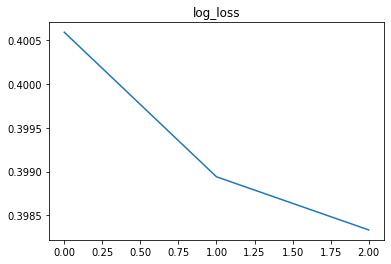

In [0]:
plt.plot(loss)
plt.title("log_loss")

Text(0.5, 1.0, 'roc_auc_score')

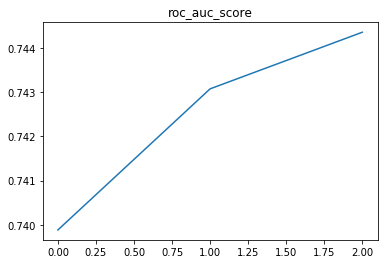

In [0]:
plt.plot(roc)
plt.title("roc_auc_score")

Text(0.5, 1.0, 'accuracy_score')

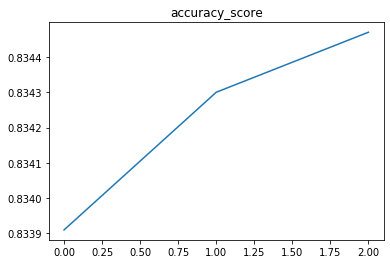

In [0]:
plt.plot(accuracy)
plt.title("accuracy_score")

# Features hashing and random forest

We restart with raw features before dummy encoding: Xtrain, Xtest.

<font color="red">**Question**:
    Display again the number of modalities per feature in Xtrain. Use '.nunique()'
</font>

In [0]:
# Fill here
Xtrain.nunique()

hour                    24
C1                       7
banner_pos               7
site_id               2591
site_domain           2777
site_category           22
app_id                3054
app_domain             196
app_category            26
device_id           136733
device_ip           509617
device_model          5076
device_type              5
device_conn_type         4
C14                   2225
C15                      8
C16                      9
C17                    420
C18                      4
C19                     66
C20                    163
C21                     60
weekday                  7
dtype: int64

We want to define a transformation which regroups the least frequent modalities into a label 'isRare'. In order to do so, we decide to define our own Transformer.

<font color="red">**Question**:
    Understand the different steps of 'fit' and 'transform'.
</font>

In [61]:
Xtrain.columns
Xtrain['C1'].value_counts()

1005    826870
1002     49319
1010     20142
1012      2570
1007       789
1001       194
1008       116
Name: C1, dtype: int64

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin

class MergeRareTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, col_names, threshold):
        self.col_names = col_names
        self.threshold = threshold

    def fit(self, X, y=None):

        X = pd.DataFrame(X)
        counts_dict_list = []
        ################## READ THIS #########################
        for i in range(len(self.col_names)):
            
            serie = X[self.col_names[i]].value_counts()  # Série des counts de chaque modalité
            rare_indexes = serie[serie<self.threshold[i]].index  # A quoi correspondent ces indices ?
            frequent_indexes = serie[serie>=self.threshold[i]].index  # A quoi correspondent ces indices ?
            dico = {x:'isRare' for x in rare_indexes}
            dico.update({x: str(x) for x in frequent_indexes})
            counts_dict_list.append(dico)   # Quel est le dictionnaire obtenu ?
            
        ######################################################
            
        self.counts_dict_list_ = counts_dict_list
        return self

    def transform(self, X):

        Xt = pd.DataFrame()
        ################## READ THIS #########################
        for col, count_dict in zip(self.col_names, self.counts_dict_list_):
            Xt[col] = X[col].apply(lambda x:count_dict[x] if x in count_dict else 'isRare')
            # A quoi sert le "else 'isRare'" dans la transformation de la colonne ?
        ######################################################

        return Xt


<font color="red">**Question:**
    <br>
    - Fit and transform the training set. To do so, merge all mmodalities occuring at least 20 times in each column.
    <br>
    - Transform the test set.
</font>

In [0]:
mg = MergeRareTransformer(col_names=Xtrain.columns, threshold=[20]*len(Xtrain.columns))
Xtrain_mg = mg.fit_transform(Xtrain) # Fill here with fit_transform
Xtest_mg = mg.transform(Xtest)

<font color="red">**Question:**
   How many elements of the column Xtrain_mg['app_domain'] are now labeled as 'rare'? Use the '.value_counts()' method.
</font>

In [64]:
# Fill here
Xtrain['app_domain'].value_counts().shape[0]-Xtrain_mg['app_domain'].value_counts().shape[0]

143

<font color="red">**Question:**
   In the new train set, display the number of modalities for each feature.
</font>

In [65]:
# Fill here
Xtrain_mg.nunique()

hour                  24
C1                     7
banner_pos             7
site_category         18
app_id               613
app_domain            53
app_category          19
device_type            5
device_conn_type       4
C14                 1339
C15                    8
C16                    9
C17                  381
C18                    4
C19                   63
C20                  148
C21                   60
weekday                7
user                 901
site                 889
dtype: int64

Modalities are arbitrary object, such as '234', 'isRare', etc. We will now transorm them into integers with the hashing trick.

<font color="red">**Question:**
   To better understand how the 'hash' function is working, apply it to a string of your choice.
</font>

In [66]:
import hashlib
hash( 'cool' ) # Fill here

5963172017822759427

<font color="red">**Question:**
   Create two new datasets 'Xtrain_ha' and 'Xtest_ha' containing the output of the hashing process. Use the '.apply' method to transform iteratively the columns by mapping to each value its remainder in the euclidean division of the hash by 1000000. 
   Example:
</font>
</font>
<p>
<center>
2060777048690<font color="red">918393</font>  -->  918393
</center>
Remark: do not forget that the function 'hash' has to take a string as input.

In [0]:
Xtrain_ha = pd.DataFrame()
Xtest_ha = pd.DataFrame()
for col in Xtrain_mg.columns:
    Xtrain_ha[col] = Xtrain_mg[col].apply(lambda x: hash(str(x)) % 1000000  ) # Fill here defining a lambda function
    Xtest_ha[col] = Xtest_mg[col].apply(lambda x: hash(str(x)) % 1000000)

<font color="red">**Question:**
   Visualize the content of the DataFrames you have obtained.
</font>

In [68]:
# Fill here
Xtrain_ha.head()

,hour,C1,banner_pos,site_category,app_id,app_domain,app_category,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,weekday,user,site
92438,795734,669576,334198,853913,684525,655743,122227,339330,758608,332614,404281,546352,545067,514849,248396,927099,917403,514849,387542,728739
60898,849310,147576,514849,853913,459506,305561,745182,334198,845508,332614,404281,546352,545067,514849,248396,927099,917403,334198,387542,728739
556199,339330,147576,514849,330749,615968,655743,499383,334198,845508,918678,404281,546352,466778,514849,362346,927099,662597,514849,387542,403100
193129,973335,147576,334198,330749,615968,655743,499383,334198,514849,957408,404281,546352,59992,514849,747670,202382,805368,334198,387542,105916
231985,278997,147576,514849,697780,615968,655743,499383,334198,514849,535044,404281,546352,545067,514849,248396,981336,917403,758665,387542,290633


<font color="red">**Question:**
    <br>
    - Train a RandomForestClassifier on Xtrain_ha and evaluate its performance on Xtest_ha. Chose 256 estimators, min_samples_leaf=20 and verbose=1 in order to monitor the fitting step. (If you have enough time, try later with 1024 estimators and min_samples_leaf=20).
    <br>
    - How do you fix 'n_jobs'? 
</font>

In [0]:
from sklearn.ensemble import RandomForestClassifier # Fill here
rf = RandomForestClassifier( n_estimators=256,min_samples_leaf=20,verbose=1,n_jobs=-1 )
%time rf.fit( Xtrain_ha,ytrain )

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  3.5min


CPU times: user 9min, sys: 944 ms, total: 9min 1s
Wall time: 4min 34s


[Parallel(n_jobs=-1)]: Done 256 out of 256 | elapsed:  4.6min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=256,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)

In [0]:
soft = rf.predict_proba(Xtest_ha)[:,1]
log_loss(ytest, soft), roc_auc_score(ytest, soft)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    3.6s
[Parallel(n_jobs=2)]: Done 256 out of 256 | elapsed:    4.8s finished


(0.39861737178115125, 0.7463396830809754)

<font color="red">**Question:**
   Compare with xgboost performance on the same hashed dataset, with n_estimators=256, n_jobs=-1, learning_rate=1.0. (If you have enough time try n_estimators=1024, n_jobs=-1, learning_rate=0.5, it will perform better than a Random Forest of 1024 trees).
</font>

In [0]:
# Fill here
from xgboost import XGBClassifier

xgb = XGBClassifier( learning_rate=1 , n_estimators=256 , n_jobs=-1)

%time xgb.fit(  Xtrain_ha , ytrain ) # the '%time' command will return the execution time of the fitting step

soft = rf.predict_proba(Xtest_ha)[:,1]
log_loss(ytest, soft), roc_auc_score(ytest, soft)

CPU times: user 5min 7s, sys: 512 ms, total: 5min 8s
Wall time: 2min 38s


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    3.6s
[Parallel(n_jobs=2)]: Done 256 out of 256 | elapsed:    4.7s finished


(0.39861737178115125, 0.7463396830809754)

<font color="red">**Question:**
    Plot the ROC and the lift curves for the obtained classifier (xgboost on hashed data). What is the lift of the first fifth of the population identified by the test?
</font>

Text(0.5, 1.0, 'ROC curve')

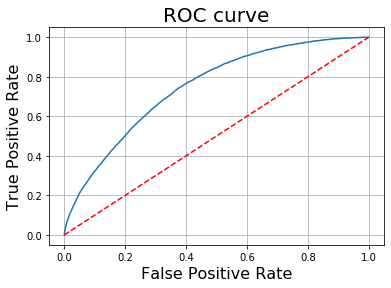

In [0]:
# Plot the ROC curve here
from sklearn.metrics import roc_curve

false_pos_rate, true_pos_rate, _ = roc_curve( ytest,soft )
plt.plot(false_pos_rate,true_pos_rate)

plt.grid()
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=20)

[]

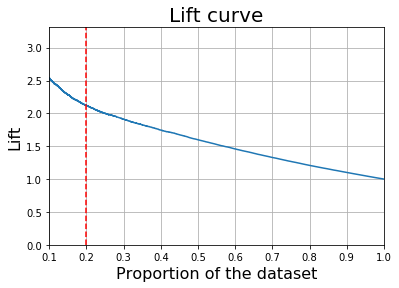

In [0]:
# Plot the lift curve here
from utils import plotlift

plotlift(ytest,soft)
# The following line just plots a vertical line for you to answer the second part of the question
plt.axvline(x= 0.2 , linestyle='--', color='r') # Fill here

plt.xlabel('Proportion of the dataset', fontsize=16)
plt.ylabel('Lift', fontsize=16)
plt.title('Lift curve', fontsize=20)
plt.plot()

Your answer here

The lift of the first fifth of the population is 2.1.

Hashing produces columns of integers arbitrarily ordered. One can wonder if adding more columns hashed in a different fashion would lead to better performance. 

<font color="red">**Question:**
    Add hashed columns by recursively hashing the previous ones: complete the following code. 
</font>

In [0]:
Xtrain_haha = pd.DataFrame(Xtrain_ha).copy()
Xtest_haha = pd.DataFrame(Xtest_ha).copy()

n_hash = 3
cols = Xtrain_ha.columns
for l in range(n_hash):
    for col in cols:
        Xtrain_haha[col + '-hash'] = Xtrain_haha[col].apply( lambda x: hash(str(x)) % 1000000 )
        Xtest_haha[col + '-hash'] = Xtest_haha[col].apply( lambda x: hash(str(x)) % 1000000 )
    cols = [col + '-hash' for col in cols]

<font color="red">**Question:**
    Evaluate the performance of a random forest and/or an xgboost clasifier (chose 256 estimators first and learning rate of 1.0 for xgboost) on these enlarged dataset. Is the performance better than when hasing features once?
</font>

In [0]:
# Fill here
from xgboost import XGBClassifier

xgb = XGBClassifier( learning_rate=1.0 , n_estimators=256 , n_jobs=-1)

%time xgb.fit(  Xtrain_haha , ytrain ) # the '%time' command will return the execution time of the fitting step

soft = xgb.predict_proba(Xtest_haha)[:,1]
log_loss(ytest, soft), roc_auc_score(ytest, soft)

CPU times: user 17min 3s, sys: 817 ms, total: 17min 4s
Wall time: 8min 42s


(0.3995224425254899, 0.7445811983596664)

In [0]:
rf = RandomForestClassifier( n_estimators=256,min_samples_leaf=20,verbose=1,n_jobs=-1 )
%time rf.fit( Xtrain_haha,ytrain )

soft = rf.predict_proba(Xtest_haha)[:,1]
log_loss(ytest, soft), roc_auc_score(ytest, soft)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 256 out of 256 | elapsed: 11.3min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


CPU times: user 22min 12s, sys: 2.31 s, total: 22min 15s
Wall time: 11min 17s


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    5.3s
[Parallel(n_jobs=2)]: Done 256 out of 256 | elapsed:    6.9s finished


(0.39608489834705507, 0.7507738293253283)

Your answer here

The performance become better, especially for the xgboost clasifier.

Good job! :-) 

<font color="red">**Bonus Question:**
    If you have enough time (about 2 hours ...), try to fit both random forest and xgboost models with 1024 estimators (and a learning rate of 0.5 for xgboost) on these enlarged datasets.<br>
    - Which one performs better?<br> 
    - Can you see the improvement due to the addition of more hashed features?
</font>

# Field-aware Factorization Machines
<br>
<font color="red">
Display the names of the columns of the matrix Xtrain_ha
</font>

In [0]:
Xtrain_ha.columns

Index(['hour', 'C1', 'banner_pos', 'site_category', 'app_id', 'app_domain',
       'app_category', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16',
       'C17', 'C18', 'C19', 'C20', 'C21', 'weekday', 'user', 'site'],
      dtype='object')

<font color="red">
Create a list of lists of the columns. The n-th sub-list is composed of the names of the columns of the n-th field.</font>

In [0]:
fields = []
fields.append( ['hour','weekday'] )
fields.append( ['C1','C14', 'C15', 'C16',
       'C17', 'C18', 'C19', 'C20', 'C21'] )
fields.append( [ 'app_id', 'app_domain',
       'app_category', 'device_type', 'device_conn_type'] )
fields.append(['banner_pos','site_category','device_conn_type','user', 'site'])

<font color="red">
With the enumerate function, let generate a dictionary which associates each column name with its field.


In [0]:
dicFields = { name_col : i  for i,f in enumerate(fields) for name_col in f}

We need to make sure that two different columns have different modalities. For this, we add in front of each modality a characteristic string of the column.

<font color="red">Perform this transformation with the apply method</font>


In [0]:
Xtrain_ffm = pd.DataFrame()
Xtest_ffm = pd.DataFrame()
for col in Xtrain_ha.columns:
    Xtrain_ffm[col] = Xtrain_ha[col].apply( lambda x: hash(str(x)+col) )
    Xtest_ffm[col] = Xtest_ha[col].apply( lambda x: hash(str(x)+col) )

With np.unique, we create the list of all the modalities appearing in all the columns.

In [0]:
allvals = []
allcols_ffm = [col for f in fields for col in f]  # Toutes les colonnes appartenant à l'un des champ
for col in allcols_ffm:
    allvals.append(np.unique(Xtrain_ffm[col]))
allvals= [val for sublist in allvals for val in sublist]

<font color="red">
Using enumerate method, create a dictionary that at each value associates its rank in the allvals list.</font>

In [0]:
dicFeat = {val:i for i,val in enumerate(allvals) }

We build dataframe from dicFeat as follows:
in each "col" column, the value "x" is replaced by the string "f: v: 1", where f is the field associated with the column and v is the index of the modality x.
<font color="red">
Study the following code</font>

In [0]:
for col in allcols_ffm:
    f = dicFields[col]
    Xtrain_ffm[col] = Xtrain_ffm[col].apply(lambda x:"{}:{}:1".format(f,dicFeat[x]) if x in dicFeat else "")
    Xtest_ffm[col] = Xtest_ffm[col].apply(lambda x:"{}:{}:1".format(f,dicFeat[x]) if x in dicFeat else "")

<font color="red">For the two resulting dataframes, concatenate on the left the corresponding ytrain (or ytest) click column</font>

In [0]:
yXtrain_ffm = pd.concat( (ytrain,Xtrain_ffm) ,axis=1)
yXtest_ffm = pd.concat( (ytest,Xtest_ffm) ,axis=1)

<font color="red">What does the following cell produce?</font>

In [0]:
yXtrain_ffm['click']=yXtrain_ffm['click'].apply(lambda x:str(x))
yXtest_ffm['click']=yXtest_ffm['click'].apply(lambda x:str(x))

yXtrain_ffm.head()

,click,hour,C1,banner_pos,site_category,app_id,app_domain,app_category,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,weekday,user,site
92438,1,0:5:1,1:32:1,3:2745:1,3:2758:1,2:2282:1,2:2692:1,2:2716:1,2:2739:1,,1:918:1,1:1383:1,1:1389:1,1:1527:1,1:1776:1,1:1841:1,1:1855:1,1:2025:1,0:24:1,3:3067:1,3:4419:1
60898,0,0:7:1,1:35:1,3:2746:1,3:2758:1,2:2530:1,2:2698:1,2:2720:1,2:2738:1,,1:918:1,1:1383:1,1:1389:1,1:1527:1,1:1776:1,1:1841:1,1:1855:1,1:2025:1,0:26:1,3:3067:1,3:4419:1
556199,0,0:4:1,1:35:1,3:2746:1,3:2753:1,2:2187:1,2:2692:1,2:2733:1,2:2738:1,,1:427:1,1:1383:1,1:1389:1,1:1446:1,1:1776:1,1:1831:1,1:1855:1,1:2033:1,0:24:1,3:3067:1,3:4428:1
193129,0,0:6:1,1:35:1,3:2745:1,3:2753:1,2:2187:1,2:2692:1,2:2733:1,2:2738:1,,1:926:1,1:1383:1,1:1389:1,1:1574:1,1:1776:1,1:1788:1,1:1982:1,1:2049:1,0:26:1,3:3067:1,3:4008:1
231985,0,0:13:1,1:35:1,3:2746:1,3:2762:1,2:2187:1,2:2692:1,2:2733:1,2:2738:1,,1:206:1,1:1383:1,1:1389:1,1:1527:1,1:1776:1,1:1841:1,1:1961:1,1:2025:1,0:28:1,3:3067:1,3:3698:1


In [0]:
train_w = yXtrain_ffm.apply(lambda row:' '.join(row.values),axis=1).values
test_w = yXtest_ffm.apply(lambda row:' '.join(row.values),axis=1).values

<font color="red">Write the above dataframe in a text file</font>

In [0]:
root_path = '/content/gdrive/My Drive/Colab Notebooks/tp_avazu/notebooks'  # your new root path
os.chdir(root_path)
os.getcwd()
os.listdir('.')

['__pycache__',
 'ffm-predict',
 'utils.py',
 'time_estimation_python.txt',
 'TP0-titanic-blank.ipynb',
 'ffm-train',
 'TP1-avazu-blank.ipynb',
 'train.txt',
 'test.txt']

In [0]:
thefile = open('train.txt','w')
for item in train_w:
    thefile.write("%s\n" % item)

# Faire de même pour le test set
thefile = open('test.txt','w')
for item in test_w:
    thefile.write("%s\n" % item)

To learn the FFM model, we use the LibFFM library https://www.csie.ntu.edu.tw/~cjlin/libffm/
In the notebooks / directory there are two executables: ffm-train and ffm-predict.
In jupyter notebook, the exclamation point! allows to launch a bash command.
The use is as follows:

-   `ffm-train'

    usage: ffm-train [options] training_set_file [model_file]

    options:  
    -l <lambda>: set regularization parameter (default 0.00002)  
    -k <factor>: set number of latent factors (default 4)  
    -t <iteration>: set number of iterations (default 15)  
    -r <eta>: set learning rate (default 0.2)  
    -s <nr_threads>: set number of threads (default 1)  
    -p <path>: set path to the validation set  
    --quiet: quiet model (no output)  
    --no-norm: disable instance-wise normalization  
    --auto-stop: stop at the iteration that achieves the best validation loss (must be used with -p)  
<br>
<font color="red">Learn the model. We can :
- use an regularizer of 0.00001
- use a learning rate of 0.05
- use of the order of 15 latent factors
- carry out the order of 30 iterations
- with the -p option, change the test file to validation parameters
- activate the --autostop mode
</font> 

In [0]:
import subprocess

#os.system("start ffm-train")
#os.startfile("ffm-train")
#cmd = './libffm/libffm/ffm-train --auto-stop -r 0.1 -t 32 -s {nr_thread} -p ./data/valid_ffm.txt ./data/train_ffm.txt model_ffm'.format(nr_thread=NR_THREAD) 


cmd = './ffm-train --auto-stop  -p test.txt  -l 0.00001 -r 0.05 -k 15 -t 30 train.txt'
#ffm-train --auto-stop  -p test.txt  -l 0.00001 -r 0.05 -k 15 -t 30 train.txt model
subprocess.call(cmd,shell=True)

126

In [0]:
os.listdir()

['__pycache__',
 'ffm-predict',
 'utils.py',
 'time_estimation_python.txt',
 'TP0-titanic-blank.ipynb',
 'ffm-train',
 'TP1-avazu-blank.ipynb',
 'train.txt',
 'test.txt']

The use of ffm-predict is: ffm-predict filename-test file-name-model file-in-which-write-the-prediction 
<font color="red">Perform the prediction</font>



<font color="red">Compute the log_loss and area under the roc curve (ROC AUC).</font>

# Blending

<font color="red">
Split Xtrain in two: Xtrain_meth and Xtrain_blend.</font>

In [0]:
Xtrain_meth, Xtrain_blend, ytrain_meth, ytrain_blend = train_test_split(Xtrain_ha,ytrain,test_size=0.2)

<font color="red">
Train a logistic regression on XTrain_meth. Then compute its score on Xtrain_blend and save the score in a vector.</font>

In [119]:
lr=LogisticRegression()
lr.fit(Xtrain_meth,ytrain_meth)
score=lr.score(Xtrain_blend,ytrain_blend)
print("The score is :",score)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The score is : 0.8306055555555556


In [0]:
score_lr_vector=lr.predict_proba(Xtrain_blend)

<font color="red">
Do the same thing with XGBoost (save the score).</font>

In [132]:
from xgboost import XGBClassifier
xgb=XGBClassifier()
xgb.fit(Xtrain_meth,ytrain_meth)
score_xgb=xgb.score(Xtrain_blend,ytrain_blend)
print("The score is :",score_xgb)

The score is : 0.83235


In [0]:
score_xgb_vector=xgb.predict_proba(Xtrain_blend)

<font color="red">
Do the same with a RandomForest (save the score).</font>

In [133]:
from sklearn.ensemble import RandomForestClassifier 
rf=RandomForestClassifier()
rf.fit(Xtrain_meth,ytrain_meth)
score_rf=rf.score(Xtrain_blend,ytrain_blend)
print("The score is :",score_rf)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


The score is : 0.79975


In [0]:
score_rf_vector=rf.predict_proba(Xtrain_blend)

<font color="red">
Now with an extraTrees.</font>

In [125]:
from sklearn.ensemble import ExtraTreesClassifier
et=ExtraTreesClassifier()
et.fit(Xtrain_meth,ytrain_meth)
score_et=et.score(Xtrain_blend,ytrain_blend)
print("The score is :",score_et)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


The score is : 0.8076277777777778


In [0]:
score_et_vector=et.predict_proba(Xtrain_blend)

<font color="red">
And again with FFM.</font>

<font color="red">
Concatenate all scores on Xtrain_blend to form a Zblend design matrix.</font>

In [0]:
Zblend=np.concatenate((score_lr_vector,score_xgb_vector,score_rf_vector,score_et_vector),axis=1)

<font color="red">
Train a logistic regression on (Zblend,ytrain_blend).</font>

In [128]:
lr_blend=LogisticRegression()
lr_blend.fit(Zblend,ytrain_blend)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

<font color="red">
Evaluate the performance of this model on the test dataset.</font>

In [129]:
Xtrain_meth, Xtrain_blend, ytrain_meth, ytrain_blend = train_test_split(Xtest_ha,ytest,test_size=0.2)
lr=LogisticRegression()
lr.fit(Xtrain_meth,ytrain_meth)
score_lr_vector=lr.predict_proba(Xtrain_blend)

xgb=XGBClassifier()
xgb.fit(Xtrain_meth,ytrain_meth)
score_xgb_vector=xgb.predict_proba(Xtrain_blend)

rf=RandomForestClassifier()
rf.fit(Xtrain_meth,ytrain_meth)
score_rf_vector=rf.predict_proba(Xtrain_blend)

et=ExtraTreesClassifier()
et.fit(Xtrain_meth,ytrain_meth)
score_et_vector=et.predict_proba(Xtrain_blend)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [131]:
Zblend_test=np.concatenate((score_lr_vector,score_xgb_vector,score_rf_vector,score_et_vector),axis=1)
score_zblend=lr_blend.score(Zblend_test,ytrain_blend)
print("The score is :",score_zblend)

The score is : 0.83155


(0.41481453796232437, 0.7129769401280981)

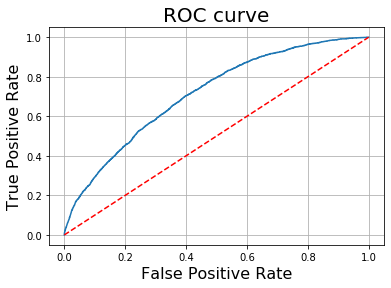

In [134]:
soft=lr_blend.predict_proba(Zblend_test)
false_pos_rate, true_pos_rate, _ = roc_curve( ytrain_blend,soft[:,1] )
plt.plot(false_pos_rate,true_pos_rate)

plt.grid()
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=20)

log_loss( ytrain_blend,soft[:,1] ), roc_auc_score( ytrain_blend,soft[:,1] )